# Chapter 24: Time Series Prediction with Multilayer Perceptions

## 1. Preparation

### Import

In [71]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import math
from keras.models import Sequential
from keras.layers import Dense

# fix random seed
seed = 7
np.random.seed(seed)

# gloabl setting
look_back = 8  # the number of time step that be used for predict

### Download Dataset

Download csv formatting international airline passengers data from [here](https://datamarket.com/data/set/22u3/international-airline-passengers-monthly-totals-in-thousands-jan-49-dec-60#!ds=22u3&display=line), and stored at ./data_set directory. The file name is "international-airline-passengers.csv".

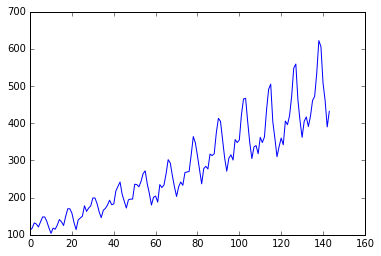

(144, 1)


In [72]:
dataframe = pd.read_csv('./data_set/international-airline-passengers.csv', usecols=[1], engine='python', skipfooter=3)
dataset = dataframe.values.astype('float32')
plt.plot(dataset)
plt.show()
print dataset.shape

## Prepare Dataset

In [73]:
# split dataset
split_point = int(len(dataset) * 0.67)
data_train = dataset[0: split_point]
data_val = dataset[split_point: ]

Transform dataset to standard training format.

In [74]:
def create_dataset(time_series, look_back=1):
    '''transform time_series to matrix data format '''
    time_series = np.array(time_series).reshape((len(time_series), ))
    X, Y = [], []
    for i in range(0, len(time_series) - look_back - 1):
        X.append(time_series[i: i+look_back])
        Y.append(time_series[i+look_back])
    return np.array(X), np.array(Y)

X_train, Y_train = create_dataset(data_train, look_back)
X_val, Y_val = create_dataset(data_val, look_back)

print X_train[0: 5], Y_train[0: 5]

[[ 112.  118.  132.  129.  121.  135.  148.  148.]
 [ 118.  132.  129.  121.  135.  148.  148.  136.]
 [ 132.  129.  121.  135.  148.  148.  136.  119.]
 [ 129.  121.  135.  148.  148.  136.  119.  104.]
 [ 121.  135.  148.  148.  136.  119.  104.  118.]] [ 136.  119.  104.  118.  115.]


## 2. Build a FC Model

In [75]:
# define a fc model
def create_fc_model():
    model = Sequential()
    model.add(Dense(16, input_dim=look_back, init='normal', activation='relu'))
    model.add(Dense(32, init='normal', activation='relu'))
    model.add(Dense(32, init='normal', activation='relu'))
    model.add(Dense(1, init='normal'))
    model.compile(loss='mse', optimizer='adam', metrics=['mae'])
    print(model.summary())
    return model

fcnn = create_fc_model()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_24 (Dense)                 (None, 16)            144         dense_input_10[0][0]             
____________________________________________________________________________________________________
dense_25 (Dense)                 (None, 32)            544         dense_24[0][0]                   
____________________________________________________________________________________________________
dense_26 (Dense)                 (None, 32)            1056        dense_25[0][0]                   
____________________________________________________________________________________________________
dense_27 (Dense)                 (None, 1)             33          dense_26[0][0]                   
Total params: 1777
________________________________________________________________________

In [76]:
# train model
fcnn.fit(X_train, Y_train, validation_data=(X_val, Y_val), batch_size=10, nb_epoch=150, verbose=1)

Train on 87 samples, validate on 39 samples
Epoch 1/150
87/87 [==============================] - 0s - loss: 53303.5271 - mean_absolute_error: 220.1283 - val_loss: 182104.5813 - val_mean_absolute_error: 419.2061
Epoch 2/150
87/87 [==============================] - 0s - loss: 52935.6273 - mean_absolute_error: 219.3531 - val_loss: 179889.7179 - val_mean_absolute_error: 416.5660
Epoch 3/150
87/87 [==============================] - 0s - loss: 51891.9555 - mean_absolute_error: 217.1527 - val_loss: 174067.0493 - val_mean_absolute_error: 409.5502
Epoch 4/150
87/87 [==============================] - 0s - loss: 49411.4306 - mean_absolute_error: 211.6949 - val_loss: 160426.3061 - val_mean_absolute_error: 392.6194
Epoch 5/150
87/87 [==============================] - 0s - loss: 43774.3535 - mean_absolute_error: 199.1437 - val_loss: 133025.1174 - val_mean_absolute_error: 356.1663
Epoch 6/150
87/87 [==============================] - 0s - loss: 33862.0921 - mean_absolute_error: 173.6297 - val_loss: 86

In [77]:
# evaluate model
socres = fcnn.evaluate(X_val, Y_val, verbose=0)
print("Mean Absoluate Error: %s"%(socres[1]))

Mean Absoluate Error: 48.8569977589


## 3. Predict Time Series

In [78]:
def predict_by_model(model, look_back, start_series, nb_predict=10):
    """
    input:
    - start_series: np.narray. (None, )
    output:
    - output: np.array. (nb_predict, )
    """
    
    len_series = len(start_series)
    if len_series < look_back:
        raise Exception("the length of start_series must longer than look_back")
    
    iterate_series = start_series.reshape((len_series, ))
    
    for i in range(nb_predict):
        features = iterate_series[len(iterate_series) - look_back :].reshape((1, look_back))
        next_value = model.predict(features)[0]
        iterate_series = np.append(iterate_series, next_value)
    
    output = iterate_series[len(iterate_series) - nb_predict:]
    
    return output

# predict by fcnn
data_predict = predict_by_model(fcnn, look_back, data_train, nb_predict = len(data_val))
print len(data_predict)

48


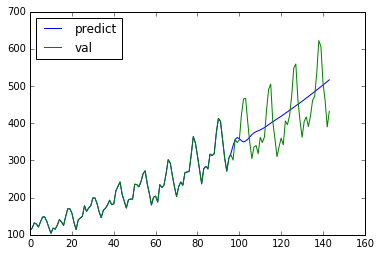

In [79]:
plt.plot(np.append(data_train, data_predict), label='predict')
plt.plot(np.append(data_train, data_val), label='val')
plt.legend(loc='upper left')
plt.show()

What a Shit!